In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSD
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Load the topology and trajectory files
u = mda.Universe("myc_091-160_stripped.prmtop", "aMD_091-160_no1-4_stripped.nc")

In [2]:
cluster_4n_indices = [
    12817, 12311, 12465, 12947, 12505, 12507, 12464, 13177, 12315, 12675,
]

In [3]:
cluster_2n_indices = [
    18257, 18657, 19346, 19548, 19729, 18430, 19584, 19767, 18218, 19809, 
]

# No Cluster 

Aligning frames: 100%|█████████████████████████| 10/10 [00:00<00:00, 185.20it/s]


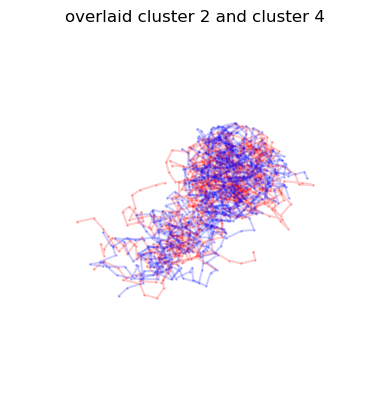

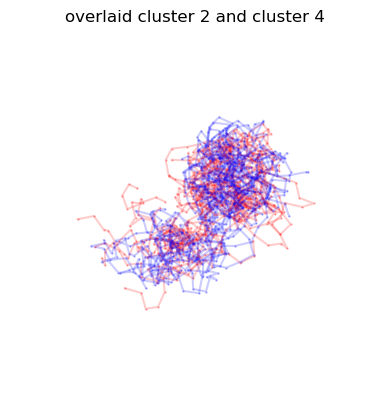

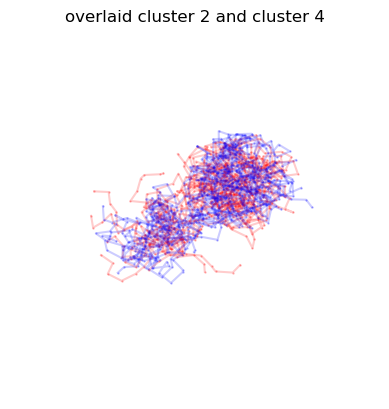

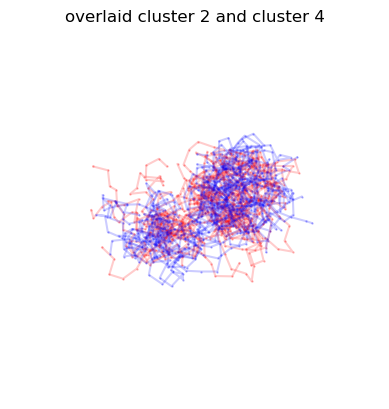

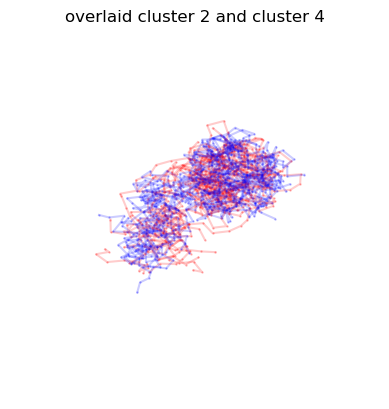

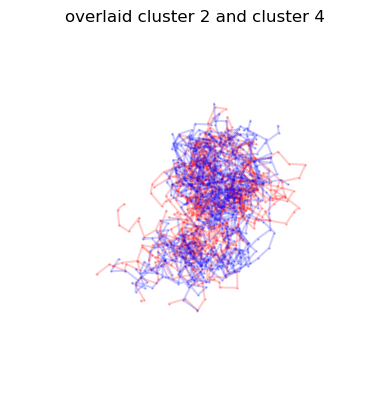

In [5]:
def extract_frames(indices, universe):
    frames = []
    for idx in tqdm(indices, desc="Extracting frames"):
        universe.trajectory[idx]
        frames.append(universe.select_atoms("name CA").positions.copy())
    return frames

# Extract frames for cluster 2 and cluster 4
frames_cluster_2 = extract_frames(cluster_2n_indices, u)
frames_cluster_4 = extract_frames(cluster_4n_indices, u)

# Create temporary Universe for alignment
def create_temp_universe(positions, universe):
    temp_universe = mda.Merge(universe.select_atoms("name CA"))
    temp_universe.atoms.positions = positions
    return temp_universe

# Align frames using AlignTraj
def align_frames(reference_universe, frames, select_for_alignment):
    aligned_frames = []
    for frame_positions in tqdm(frames, desc="Aligning frames"):
        temp_universe = create_temp_universe(frame_positions, reference_universe)
        aligner = align.AlignTraj(temp_universe, reference_universe, select=select_for_alignment, in_memory=True)
        aligner.run()
        aligned_frames.append(temp_universe.atoms.positions.copy())
    return aligned_frames

# Selection string for all backbone residues to ensure alignment of corresponding residues
select_all_backbone = "name CA"

# Function to calculate overlap counts for each frame
def calculate_overlap_counts(frames):
    overlap_counts = []
    for frame in frames:
        unique, counts_frame = np.unique(frame, axis=0, return_counts=True)
        overlap_counts.append((unique, counts_frame))
    return overlap_counts

# Function to calculate the cumulative overlap of a given frame with all other frames
def calculate_cumulative_overlap(reference_frame, frames):
    cumulative_overlap = 0
    ref_unique, ref_counts = np.unique(reference_frame, axis=0, return_counts=True)
    ref_counts_dict = {tuple(pos): count for pos, count in zip(ref_unique, ref_counts)}
    for frame in frames:
        unique, counts_frame = np.unique(frame, axis=0, return_counts=True)
        for pos, count in zip(unique, counts_frame):
            pos_tuple = tuple(pos)
            if pos_tuple in ref_counts_dict:
                cumulative_overlap += min(ref_counts_dict[pos_tuple], count)
    return cumulative_overlap

# Find the best reference frame for cluster 2
best_reference_index_2 = -1
max_cumulative_overlap_2 = -1

for i, frame in enumerate(frames_cluster_2):
    cumulative_overlap = calculate_cumulative_overlap(frame, frames_cluster_2)
    if cumulative_overlap > max_cumulative_overlap_2:
        max_cumulative_overlap_2 = cumulative_overlap
        best_reference_index_2 = i

# Find the best reference frame for cluster 4
best_reference_index_4 = -1
max_cumulative_overlap_4 = -1

for i, frame in enumerate(frames_cluster_4):
    cumulative_overlap = calculate_cumulative_overlap(frame, frames_cluster_4)
    if cumulative_overlap > max_cumulative_overlap_4:
        max_cumulative_overlap_4 = cumulative_overlap
        best_reference_index_4 = i

# Create the best reference universes for alignment
reference_universe_2 = create_temp_universe(frames_cluster_2[best_reference_index_2], u)
reference_universe_4 = create_temp_universe(frames_cluster_4[best_reference_index_4], u)

# Align frames for cluster 2 and cluster 4
aligned_frames_cluster_2 = align_frames(reference_universe_2, frames_cluster_2, select_all_backbone)
aligned_frames_cluster_4 = align_frames(reference_universe_4, frames_cluster_4, select_all_backbone)

# Plot the aligned frames from different angles
angles = [(30, 30), (60, 30), (30, 60), (60, 60), (0, 90), (90, 0)]

for angle in angles:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot cluster 2 frames with lines in red with fixed opacity
    for positions in aligned_frames_cluster_2:
        ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'o-', color='red', markersize=1, markeredgewidth=0.8, alpha=0.2)
    
    # Plot cluster 4 frames with lines in blue with fixed opacity
    for positions in aligned_frames_cluster_4:
        ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'o-', color='blue', markersize=1, markeredgewidth=0.8, alpha=0.2)
    
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_axis_off()  # Remove axes
    ax.grid(False)     # Remove grid lines
    plt.title('overlaid cluster 2 and cluster 4')
    plt.show()